In [1]:
pip install imgaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import os
from IPython.display import display, clear_output, HTML
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from pathlib import Path
import PIL
import numpy as np
from skimage import io
from skimage.color import rgba2rgb
import imgaug as ia
import imgaug.augmenters as iaa
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [4]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed = 42

#### **Augment images to increase data size per class to up to 1200 images**

In [ ]:
# # Augment images to increase data size to more than 1000 images per class

# # Set the folder path
# team_list = ['AlphaTauri F1 car', 'Ferrari F1 car', 'McLaren F1 car', 
#              'Mercedes F1 car', 'Racing Point F1 car', 'Red Bull Racing F1 car', 
#              'Renault F1 car', 'Williams F1 car']

# for team in team_list:
    

#     folder_path = f'Formula One Cars/{team}/'

#     # Define the augmentation sequence
#     seq = iaa.Sequential([
#         iaa.Fliplr(0.5),  # Horizontal flips with 50% probability
#         iaa.Affine(rotate=(-45, 45)),  # Rotate images by -45 to 45 degrees
#         iaa.Affine(scale=(0.5, 1.5)),  # Scale images by 50% to 150%
#         iaa.Multiply((0.5, 1.5)),  # Change brightness (50% to 150%)
#         iaa.GaussianBlur(sigma=(0, 2.0))  # Apply Gaussian blur with sigma between 0 and 2
#     ])

#     # Load the images
#     images = []
#     for file in os.listdir(folder_path):
#         if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
#             image_path = os.path.join(folder_path, file)
#             image = Image.open(image_path)
#             images.append(np.array(image))

#     # Number of times to augment each image to reach the desired count
#     num_augmentations_per_image = (1200 // len(images)) - 1

#     # Save the augmented images
#     output_folder = f'augmented_images/{team}'
#     os.makedirs(output_folder, exist_ok=True)


#     counter = 0
#     counter1 = 0
#     for img in images:
#         for i in range(num_augmentations_per_image):
#             aug_image = seq(image=img)
#             image = Image.fromarray(aug_image)
#             image = image.convert("RGB")  # Convert the image to RGB mode
#             image.save(os.path.join(output_folder, f'aug_image_{counter}.jpg'))
#             counter += 1
#         #save original image
#         image_org = Image.fromarray(img)
#         image_org = image_org.convert("RGB")  # Convert the image to RGB mode
#         image_org.save(os.path.join(output_folder, f'original_image_{counter1}.jpg'))
#         counter1 += 1

#### Create Dataset to train dataset and validation dataset

In [5]:
# Define data transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Set the folder path
folder_path = '/content/drive/MyDrive/Colab Notebooks/augmented_images'

class CustomImageFolder(ImageFolder):
    def _find_classes(self, dir):
        classes, class_to_idx = super()._find_classes(dir)

        # Check and remove problematic images
        for class_name in classes:
            class_path = Path(dir) / class_name
            for img_path in class_path.iterdir():
                try:
                    with Image.open(img_path) as img:
                        img.verify()  # Verify if the image is truncated

                    # Reopen the image to convert it to RGB
                    with Image.open(img_path) as img:
                        img = img.convert("RGB")
                except (PIL.UnidentifiedImageError, OSError):
                    print(f"Removing problematic image: {img_path}")
                    img_path.unlink()

        return classes, class_to_idx



# Load the dataset
dataset = CustomImageFolder(folder_path, transform=data_transforms)



In [6]:
# Split the dataset into training and validation sets
set_seed(seed)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [7]:
def make_confusion_matrix(y_true,y_preds,class_names):
    
    cm=confusion_matrix(y_true,y_preds)
    plt.figure(figsize=(14,10))
    sns.heatmap(cm,annot=True,cmap='Blues',fmt='.0f')
    display(HTML("<h2 style='font-weight:bold; color:#3498DB; text-align:center;'>Confusion Matrix</h2><hr>"))
    plt.ylabel("True values",size=15)
    plt.xlabel('Predicted values',size=15)
    plt.xticks(ticks=np.arange(len(class_names))+0.5,labels=class_names,rotation=60)
    plt.yticks(ticks=np.arange(len(class_names))+0.5,labels=class_names,rotation=0)

#### Baseline Model - 2 layer CNN Model

In [8]:
# CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(401408, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        #print("Feature shape:", x.shape)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [9]:
# Instantiate the model
num_classes = len(dataset.classes)
set_seed(seed)
model = SimpleCNN(num_classes)

# Check if GPU is available and set the device to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Move your model to GPU
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 10

for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()

    train_loss /= len(train_dataset)
    train_accuracy = train_correct / len(train_dataset)


    print(f'Epoch {epoch + 1}/{n_epochs}: Train Loss - {train_loss:.4f}, Train Accuracy - {train_accuracy:.4f}')

Using device: cuda:0
Epoch 1/10: Train Loss - 0.0594, Train Accuracy - 0.3328
Epoch 2/10: Train Loss - 0.0421, Train Accuracy - 0.4998
Epoch 3/10: Train Loss - 0.0361, Train Accuracy - 0.5723
Epoch 4/10: Train Loss - 0.0304, Train Accuracy - 0.6459
Epoch 5/10: Train Loss - 0.0249, Train Accuracy - 0.7184
Epoch 6/10: Train Loss - 0.0197, Train Accuracy - 0.7764
Epoch 7/10: Train Loss - 0.0144, Train Accuracy - 0.8437
Epoch 8/10: Train Loss - 0.0115, Train Accuracy - 0.8791
Epoch 9/10: Train Loss - 0.0091, Train Accuracy - 0.9043
Epoch 10/10: Train Loss - 0.0080, Train Accuracy - 0.9210


In [10]:
# Set the model to evaluation mode
set_seed(seed)
model.eval()

# Initialize counters
correct = 0
total = 0
pred_labels = []
true_labels = []
# No gradient calculation needed in evaluation
with torch.no_grad():
    for inputs, labels in val_loader:
        # Move inputs and labels to the device used (GPU or CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        
        # Get the predicted class
        _, predicted = torch.max(outputs, 1)

        # Update counters
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        pred_labels.append(predicted)
        true_labels.extend([l.item() for l in labels])  

val_labels = torch.cat(pred_labels)
# Calculate accuracy
accuracy = 100 * correct / total
print(f'Validation accuracy: {accuracy:.2f}%')


Validation accuracy: 51.29%


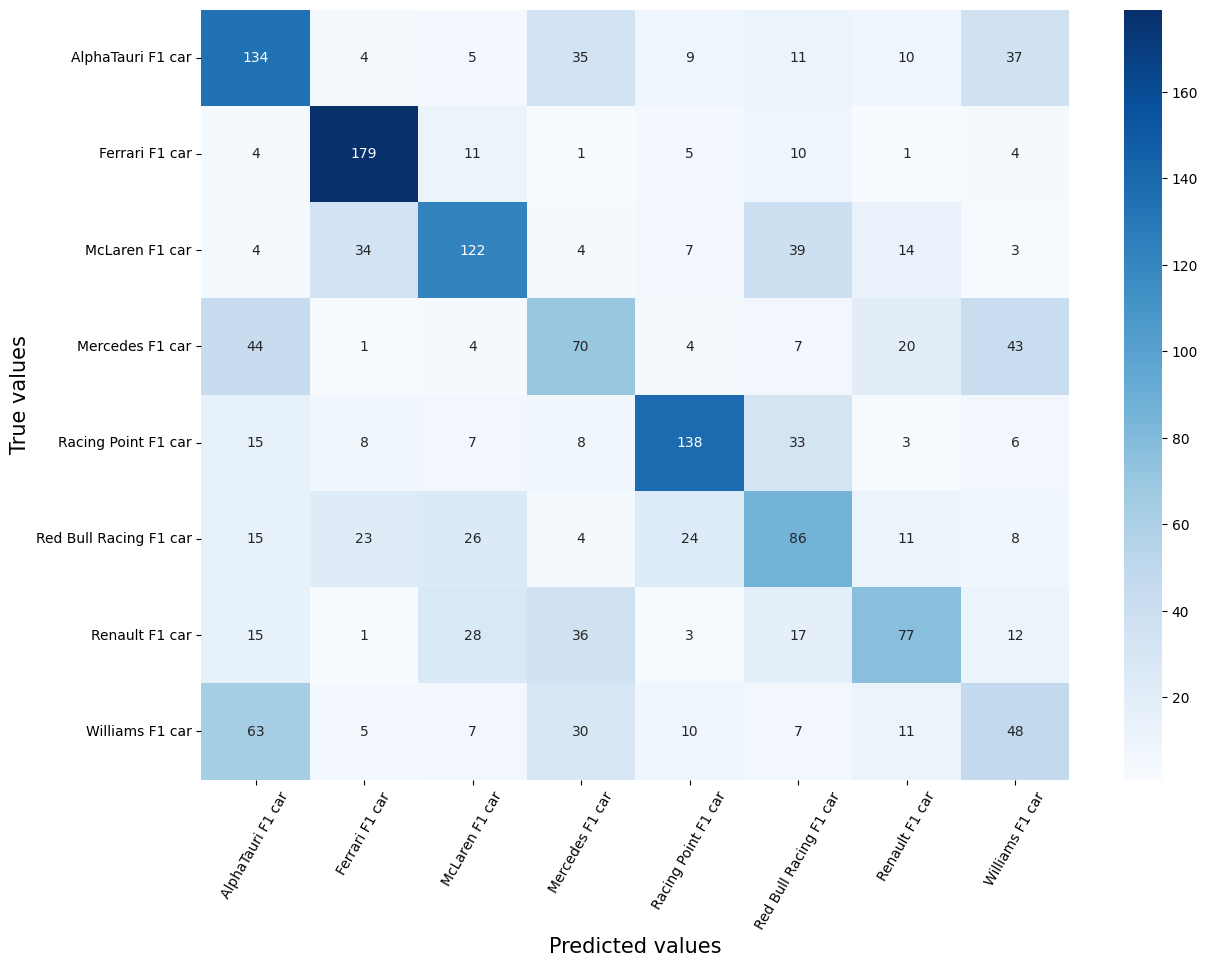

In [11]:
val_labels_cpu = val_labels.cpu()
make_confusion_matrix(true_labels,val_labels_cpu,dataset.classes)

In [ ]:
print(dataset.classes)

['AlphaTauri F1 car', 'Ferrari F1 car', 'McLaren F1 car', 'Mercedes F1 car', 'Racing Point F1 car', 'Red Bull Racing F1 car', 'Renault F1 car', 'Williams F1 car']


#### Fine Tune RESNET-18 Model - freeze all feature extraction layers

In [36]:
set_seed(seed)

# Load the pre-trained model
resnet18 = models.resnet18(pretrained=True)

# Freeze all layers
for param in resnet18.parameters():
    param.requires_grad = False

# Replace the last fully connected layer to match the number of classes in your dataset
num_classes = len(dataset.classes)
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

# Move the model to the device (GPU or CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18 = resnet18.to(device)




/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [37]:
# Set loss function and optimizer
set_seed(seed)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.0001)

# Train the model
n_epochs = 10
for epoch in range(n_epochs):
    resnet18.train()
    train_loss = 0
    train_correct = 0
    for inputs, labels in train_loader:
      
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()

    train_loss /= len(train_dataset)
    train_accuracy = train_correct / len(train_dataset)

    print(f'Epoch {epoch + 1}/{n_epochs}: Train Loss - {train_loss:.4f}, Train Accuracy - {train_accuracy:.4f}')

Epoch 1/10: Train Loss - 0.0624, Train Accuracy - 0.2388
Epoch 2/10: Train Loss - 0.0538, Train Accuracy - 0.4445
Epoch 3/10: Train Loss - 0.0475, Train Accuracy - 0.5815
Epoch 4/10: Train Loss - 0.0429, Train Accuracy - 0.6394
Epoch 5/10: Train Loss - 0.0395, Train Accuracy - 0.6696
Epoch 6/10: Train Loss - 0.0368, Train Accuracy - 0.6923
Epoch 7/10: Train Loss - 0.0348, Train Accuracy - 0.7031
Epoch 8/10: Train Loss - 0.0330, Train Accuracy - 0.7193
Epoch 9/10: Train Loss - 0.0316, Train Accuracy - 0.7261
Epoch 10/10: Train Loss - 0.0303, Train Accuracy - 0.7316


In [38]:
# Set the model to evaluation mode
set_seed(seed)
resnet18.eval()

# Initialize counters
correct = 0
total = 0
pred_labels = []
true_labels = []

# No gradient calculation needed in evaluation
with torch.no_grad():
    for inputs, labels in val_loader:
        # Move inputs and labels to the device used (GPU or CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = resnet18(inputs)
        
        # Get the predicted class
        _, predicted = torch.max(outputs, 1)

        # Update counters
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        pred_labels.append(predicted)
        true_labels.extend([l.item() for l in labels])  


val_labels = torch.cat(pred_labels)
# Calculate accuracy
accuracy = 100 * correct / total
print(f'Validation accuracy: {accuracy:.2f}%')

Validation accuracy: 73.99%


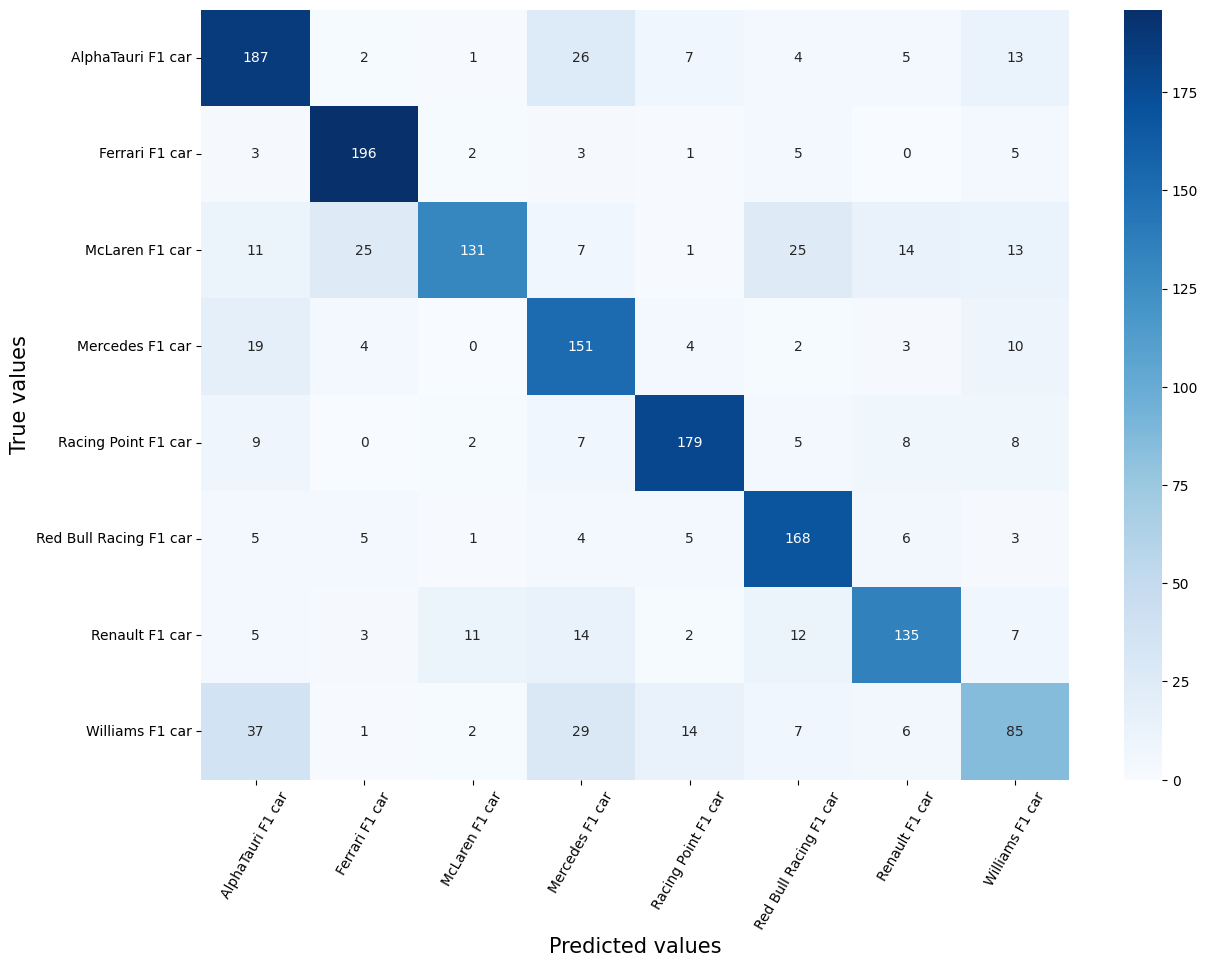

In [39]:
val_labels_cpu = val_labels.cpu()
make_confusion_matrix(true_labels,val_labels_cpu,dataset.classes)

#### Fine-Tune Full RESNET-18 Model

In [42]:
# Load pre-trained ResNet and modify for your task
num_classes = len(dataset.classes)  # Number of Formula 1 car classes
set_seed(seed)
resnet18_all = models.resnet18(pretrained=True)
resnet18_all.fc = nn.Linear(resnet18_all.fc.in_features, num_classes)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18_all = resnet18_all.to(device)



In [43]:
# Set loss function and optimizer
set_seed(seed)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18_all.parameters(), lr=0.0001)

# Train the model
n_epochs = 10
for epoch in range(n_epochs):
    resnet18_all.train()
    train_loss = 0
    train_correct = 0
    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet18_all(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()

    train_loss /= len(train_dataset)
    train_accuracy = train_correct / len(train_dataset)

    print(f'Epoch {epoch + 1}/{n_epochs}: Train Loss - {train_loss:.4f}, Train Accuracy - {train_accuracy:.4f}')

Epoch 1/10: Train Loss - 0.0172, Train Accuracy - 0.8266
Epoch 2/10: Train Loss - 0.0041, Train Accuracy - 0.9665
Epoch 3/10: Train Loss - 0.0020, Train Accuracy - 0.9833
Epoch 4/10: Train Loss - 0.0016, Train Accuracy - 0.9941
Epoch 5/10: Train Loss - 0.0010, Train Accuracy - 0.9935
Epoch 6/10: Train Loss - 0.0004, Train Accuracy - 0.9976
Epoch 7/10: Train Loss - 0.0005, Train Accuracy - 0.9964
Epoch 8/10: Train Loss - 0.0007, Train Accuracy - 0.9935
Epoch 9/10: Train Loss - 0.0009, Train Accuracy - 0.9911
Epoch 10/10: Train Loss - 0.0013, Train Accuracy - 0.9866


In [44]:
# Set the model to evaluation mode
set_seed(seed)
resnet18_all.eval()

# Initialize counters
correct = 0
total = 0
pred_labels = []
true_labels = []

# No gradient calculation needed in evaluation
with torch.no_grad():
    for inputs, labels in val_loader:
        # Move inputs and labels to the device used (GPU or CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = resnet18_all(inputs)
        
        # Get the predicted class
        _, predicted = torch.max(outputs, 1)

        pred_labels.append(predicted)
        true_labels.extend([l.item() for l in labels])  

        # Update counters
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_labels = torch.cat(pred_labels)
# Calculate accuracy
accuracy = 100 * correct / total
print(f'Validation accuracy: {accuracy:.2f}%')

Validation accuracy: 93.33%


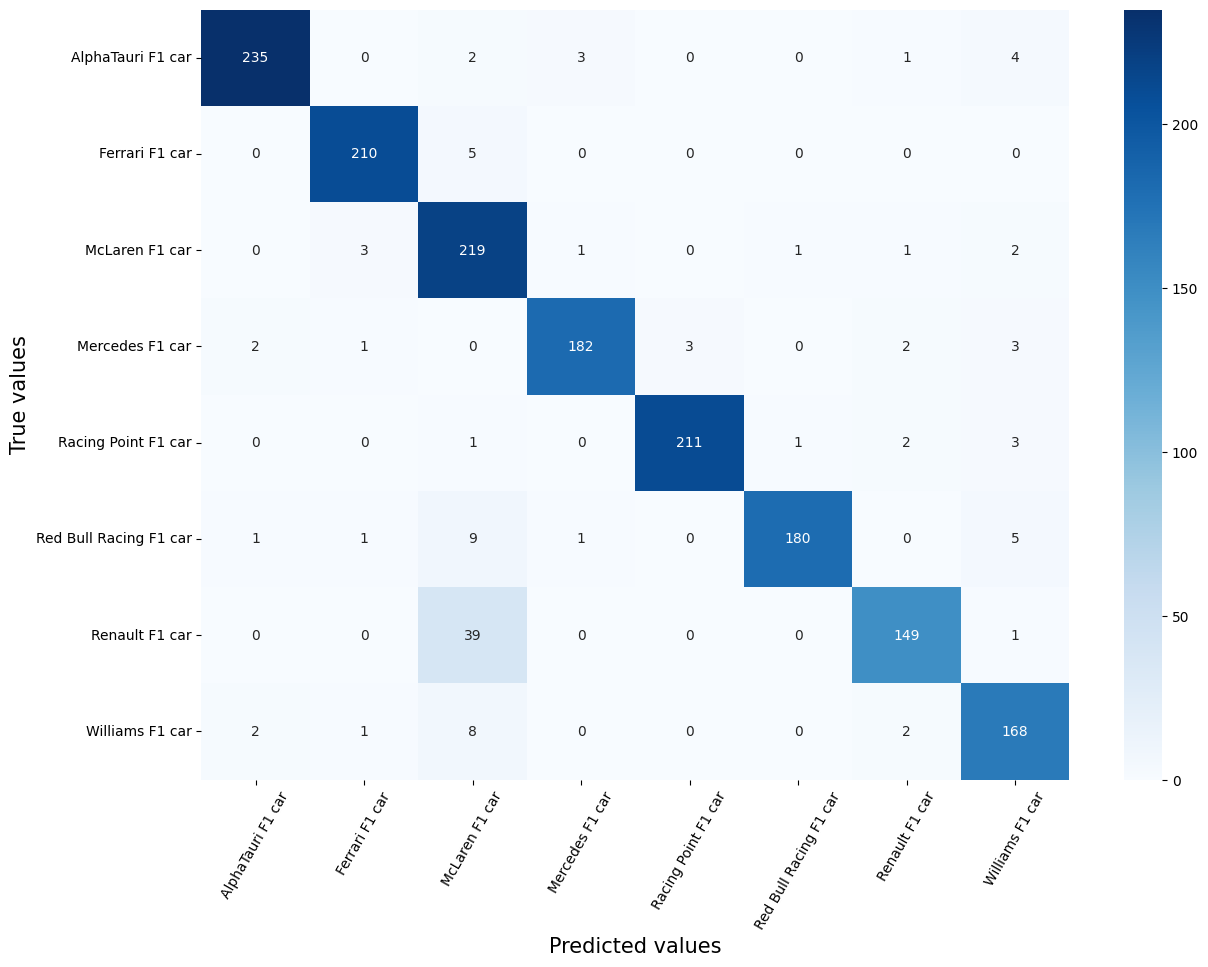

In [45]:
val_labels_cpu = val_labels.cpu()
make_confusion_matrix(true_labels,val_labels_cpu,dataset.classes)

#### Fine Tune VGG-16 model - Freeze All Feature Extraction Layers

In [20]:
# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
set_seed(seed)
# Load the pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True)

# Freeze all layers except the last one
for param in vgg16.features.parameters():
    param.requires_grad = False

# Customize the last fully connected layer for your task
num_classes = len(dataset.classes)  # Set the number of output classes for your task
vgg16.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)

# Move the model to the device
vgg16 = vgg16.to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 273MB/s]


In [21]:
# Set loss function and optimizer
set_seed(seed)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=0.001)

# Train the model
n_epochs = 10
for epoch in range(n_epochs):
    vgg16.train()
    train_loss = 0
    train_correct = 0
    for inputs, labels in train_loader:
      
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()

    train_loss /= len(train_dataset)
    train_accuracy = train_correct / len(train_dataset)

    print(f'Epoch {epoch + 1}/{n_epochs}: Train Loss - {train_loss:.4f}, Train Accuracy - {train_accuracy:.4f}')

Epoch 1/10: Train Loss - 0.0563, Train Accuracy - 0.3798
Epoch 2/10: Train Loss - 0.0384, Train Accuracy - 0.6141
Epoch 3/10: Train Loss - 0.0297, Train Accuracy - 0.7072
Epoch 4/10: Train Loss - 0.0264, Train Accuracy - 0.7543
Epoch 5/10: Train Loss - 0.0264, Train Accuracy - 0.7783
Epoch 6/10: Train Loss - 0.0219, Train Accuracy - 0.8172
Epoch 7/10: Train Loss - 0.0198, Train Accuracy - 0.8372
Epoch 8/10: Train Loss - 0.0208, Train Accuracy - 0.8459
Epoch 9/10: Train Loss - 0.0214, Train Accuracy - 0.8381
Epoch 10/10: Train Loss - 0.0205, Train Accuracy - 0.8606


In [22]:
# Set the model to evaluation mode
set_seed(seed)
vgg16.eval()

# Initialize counters
correct = 0
total = 0
pred_labels = []
true_labels = []

# No gradient calculation needed in evaluation
with torch.no_grad():
    for inputs, labels in val_loader:
        # Move inputs and labels to the device used (GPU or CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = vgg16(inputs)

        # Get the predicted class
        _, predicted = torch.max(outputs, 1)

        pred_labels.append(predicted)
        true_labels.extend([l.item() for l in labels]) 

        # Update counters
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_labels = torch.cat(pred_labels)
# Calculate accuracy
accuracy = 100 * correct / total
print(f'Validation accuracy: {accuracy:.2f}%')

Validation accuracy: 67.81%


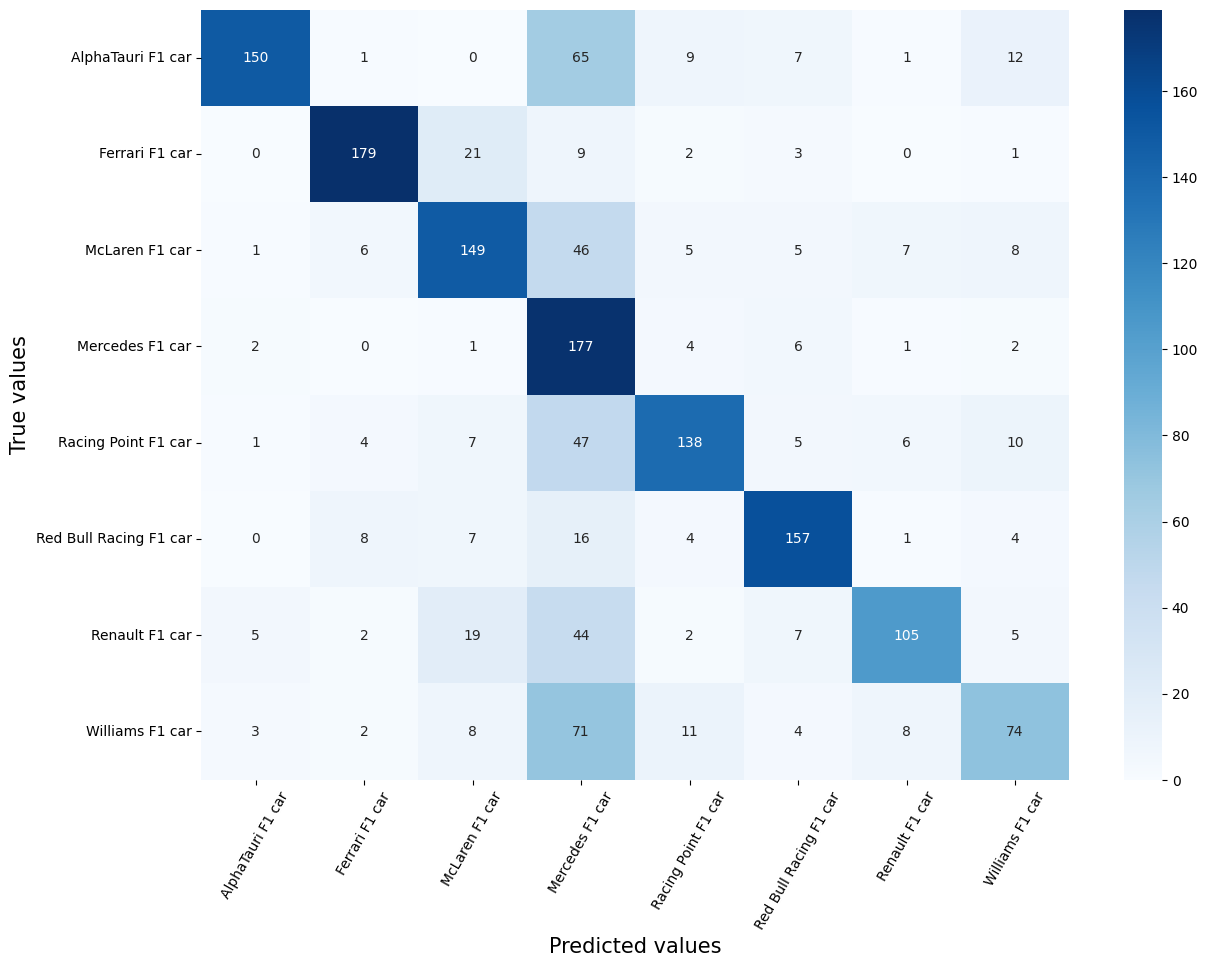

In [23]:
val_labels_cpu = val_labels.cpu()
make_confusion_matrix(true_labels,val_labels_cpu,dataset.classes)

#### Fine Tune Full VGG-16 Model

In [24]:
# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

set_seed(seed)
# Load the pre-trained VGG16 model
vgg16_all = models.vgg16(pretrained=True)



# Customize the last fully connected layer for your task
num_classes = len(dataset.classes)  # Set the number of output classes for your task
vgg16_all.classifier[6] = nn.Linear(vgg16_all.classifier[6].in_features, num_classes)

# Move the model to the device
vgg16_all = vgg16_all.to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
# Set loss function and optimizer
set_seed(seed)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16_all.parameters(), lr=0.0001)

# Train the model
n_epochs = 10
for epoch in range(n_epochs):
    vgg16_all.train()
    train_loss = 0
    train_correct = 0
    for inputs, labels in train_loader:
      
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg16_all(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()

    train_loss /= len(train_dataset)
    train_accuracy = train_correct / len(train_dataset)

    print(f'Epoch {epoch + 1}/{n_epochs}: Train Loss - {train_loss:.4f}, Train Accuracy - {train_accuracy:.4f}')

Epoch 1/10: Train Loss - 0.0258, Train Accuracy - 0.7108
Epoch 2/10: Train Loss - 0.0085, Train Accuracy - 0.9150
Epoch 3/10: Train Loss - 0.0059, Train Accuracy - 0.9413
Epoch 4/10: Train Loss - 0.0038, Train Accuracy - 0.9641
Epoch 5/10: Train Loss - 0.0047, Train Accuracy - 0.9528
Epoch 6/10: Train Loss - 0.0014, Train Accuracy - 0.9877
Epoch 7/10: Train Loss - 0.0015, Train Accuracy - 0.9860
Epoch 8/10: Train Loss - 0.0014, Train Accuracy - 0.9869
Epoch 9/10: Train Loss - 0.0012, Train Accuracy - 0.9892
Epoch 10/10: Train Loss - 0.0029, Train Accuracy - 0.9748


In [26]:
# Set the model to evaluation mode
set_seed(seed)
vgg16_all.eval()

# Initialize counters
correct = 0
total = 0
pred_labels = []
true_labels = []

# No gradient calculation needed in evaluation
with torch.no_grad():
    for inputs, labels in val_loader:
        # Move inputs and labels to the device used (GPU or CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = vgg16_all(inputs)
        
        # Get the predicted class
        _, predicted = torch.max(outputs, 1)

        pred_labels.append(predicted)
        true_labels.extend([l.item() for l in labels]) 

        # Update counters
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_labels = torch.cat(pred_labels)
# Calculate accuracy
accuracy = 100 * correct / total
print(f'Validation accuracy: {accuracy:.2f}%')

Validation accuracy: 95.74%


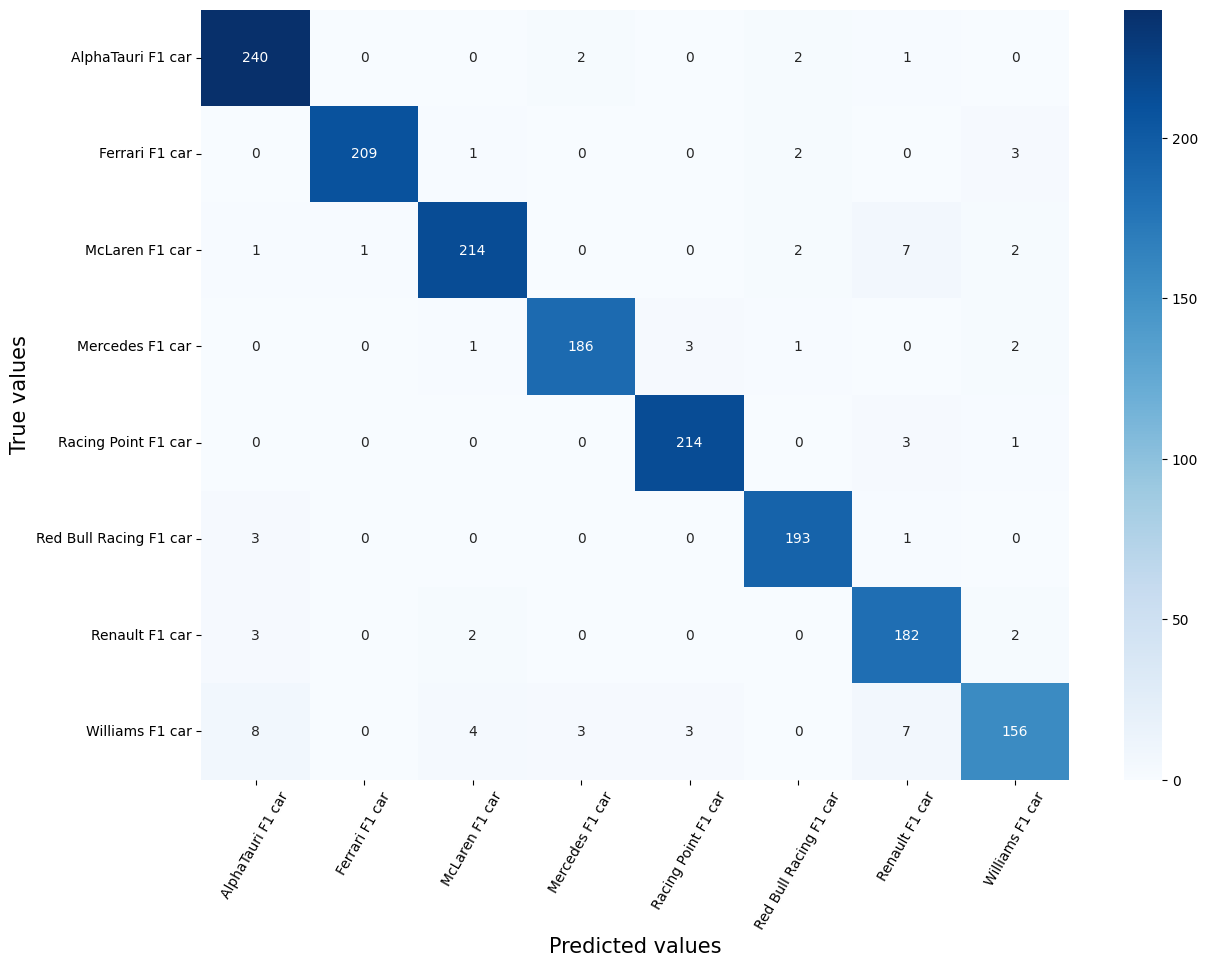

In [27]:
val_labels_cpu = val_labels.cpu()
make_confusion_matrix(true_labels,val_labels_cpu,dataset.classes)

#### Fine Tune MobileNet_V2 Model - Freeze all feature extraction layers

In [28]:
# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

set_seed(seed)
# Load the pre-trained MobilenetV2 model
mobilenet_v2 = models.mobilenet_v2(pretrained=True)

# Freeze all layers
for param in mobilenet_v2.parameters():
    param.requires_grad = False

# Customize the last fully connected layer for your task
num_classes = len(dataset.classes)
mobilenet_v2.classifier[1] = nn.Linear(mobilenet_v2.classifier[1].in_features, num_classes)

# Move the model to the device
mobilenet_v2 = mobilenet_v2.to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 63.9MB/s]


In [29]:
# Set loss function and optimizer
set_seed(seed)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_v2.parameters(), lr=0.001)

# Train the model
n_epochs = 10
for epoch in range(n_epochs):
    mobilenet_v2.train()
    train_loss = 0
    train_correct = 0
    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = mobilenet_v2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()

    train_loss /= len(train_dataset)
    train_accuracy = train_correct / len(train_dataset)

    print(f'Epoch {epoch + 1}/{n_epochs}: Train Loss - {train_loss:.4f}, Train Accuracy - {train_accuracy:.4f}')

Epoch 1/10: Train Loss - 0.0391, Train Accuracy - 0.5993
Epoch 2/10: Train Loss - 0.0260, Train Accuracy - 0.7334
Epoch 3/10: Train Loss - 0.0232, Train Accuracy - 0.7573
Epoch 4/10: Train Loss - 0.0217, Train Accuracy - 0.7728
Epoch 5/10: Train Loss - 0.0211, Train Accuracy - 0.7801
Epoch 6/10: Train Loss - 0.0200, Train Accuracy - 0.7863
Epoch 7/10: Train Loss - 0.0196, Train Accuracy - 0.7889
Epoch 8/10: Train Loss - 0.0195, Train Accuracy - 0.7842
Epoch 9/10: Train Loss - 0.0186, Train Accuracy - 0.8021
Epoch 10/10: Train Loss - 0.0186, Train Accuracy - 0.7941


In [30]:
# Set the model to evaluation mode
set_seed(seed)
mobilenet_v2.eval()

# Initialize counters
correct = 0
total = 0
pred_labels = []
true_labels = []

# No gradient calculation needed in evaluation
with torch.no_grad():
    for inputs, labels in val_loader:
        # Move inputs and labels to the device used (GPU or CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = mobilenet_v2(inputs)
      
        # Get the predicted class
        _, predicted = torch.max(outputs, 1)

        pred_labels.append(predicted)
        true_labels.extend([l.item() for l in labels]) 

        # Update counters
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_labels = torch.cat(pred_labels)
# Calculate accuracy
accuracy = 100 * correct / total
print(f'Validation accuracy: {accuracy:.2f}%')

Validation accuracy: 83.06%


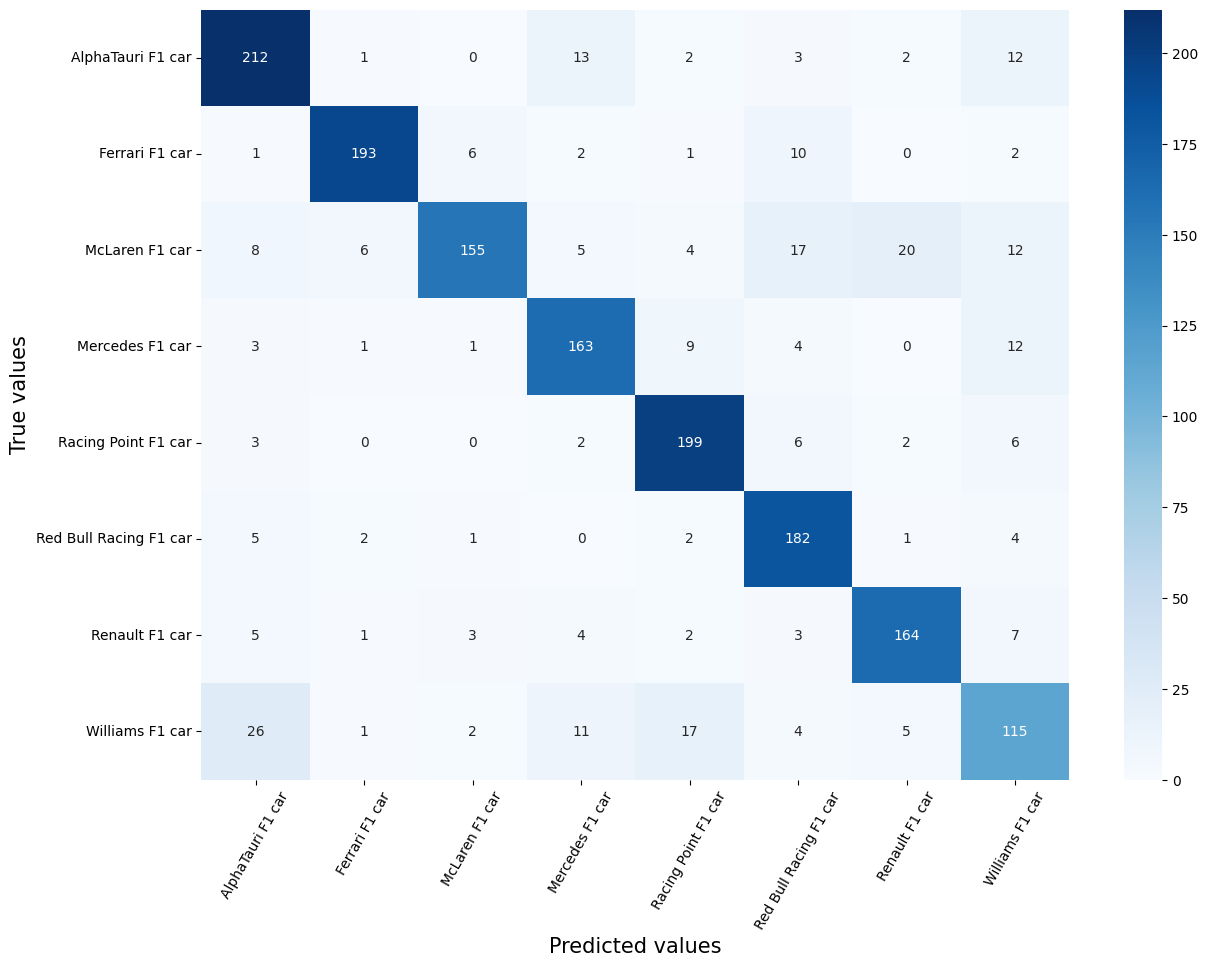

In [31]:
val_labels_cpu = val_labels.cpu()
make_confusion_matrix(true_labels,val_labels_cpu,dataset.classes)

#### Fine Tune Full MobileNet-V2 Model

In [46]:
# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

set_seed(seed)
# Load the pre-trained MobilenetV2 model
mobilenet_v2_all = models.mobilenet_v2(pretrained=True)


# Customize the last fully connected layer for your task
num_classes = len(dataset.classes)
mobilenet_v2_all.classifier[1] = nn.Linear(mobilenet_v2_all.classifier[1].in_features, num_classes)

# Move the model to the device
mobilenet_v2_all = mobilenet_v2_all.to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [47]:
# Set loss function and optimizer
set_seed(seed)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_v2_all.parameters(), lr=0.0001)

# Train the model
n_epochs = 10
for epoch in range(n_epochs):
    mobilenet_v2_all.train()
    train_loss = 0
    train_correct = 0
    for inputs, labels in train_loader:
      
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = mobilenet_v2_all(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()

    train_loss /= len(train_dataset)
    train_accuracy = train_correct / len(train_dataset)

    print(f'Epoch {epoch + 1}/{n_epochs}: Train Loss - {train_loss:.4f}, Train Accuracy - {train_accuracy:.4f}')

Epoch 1/10: Train Loss - 0.0201, Train Accuracy - 0.8013
Epoch 2/10: Train Loss - 0.0059, Train Accuracy - 0.9486
Epoch 3/10: Train Loss - 0.0031, Train Accuracy - 0.9730
Epoch 4/10: Train Loss - 0.0019, Train Accuracy - 0.9901
Epoch 5/10: Train Loss - 0.0014, Train Accuracy - 0.9875
Epoch 6/10: Train Loss - 0.0008, Train Accuracy - 0.9929
Epoch 7/10: Train Loss - 0.0013, Train Accuracy - 0.9875
Epoch 8/10: Train Loss - 0.0009, Train Accuracy - 0.9920
Epoch 9/10: Train Loss - 0.0005, Train Accuracy - 0.9968
Epoch 10/10: Train Loss - 0.0004, Train Accuracy - 0.9974


In [48]:
# Set the model to evaluation mode
set_seed(seed)
mobilenet_v2_all.eval()

# Initialize counters
correct = 0
total = 0
pred_labels = []
true_labels = []

# No gradient calculation needed in evaluation
with torch.no_grad():
    for inputs, labels in val_loader:
        # Move inputs and labels to the device used (GPU or CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = mobilenet_v2_all(inputs)
        
        # Get the predicted class
        _, predicted = torch.max(outputs, 1)

        pred_labels.append(predicted)
        true_labels.extend([l.item() for l in labels])        

        # Update counters
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


val_labels = torch.cat(pred_labels)
# Calculate accuracy
accuracy = 100 * correct / total
print(f'Validation accuracy: {accuracy:.2f}%')

Validation accuracy: 96.34%


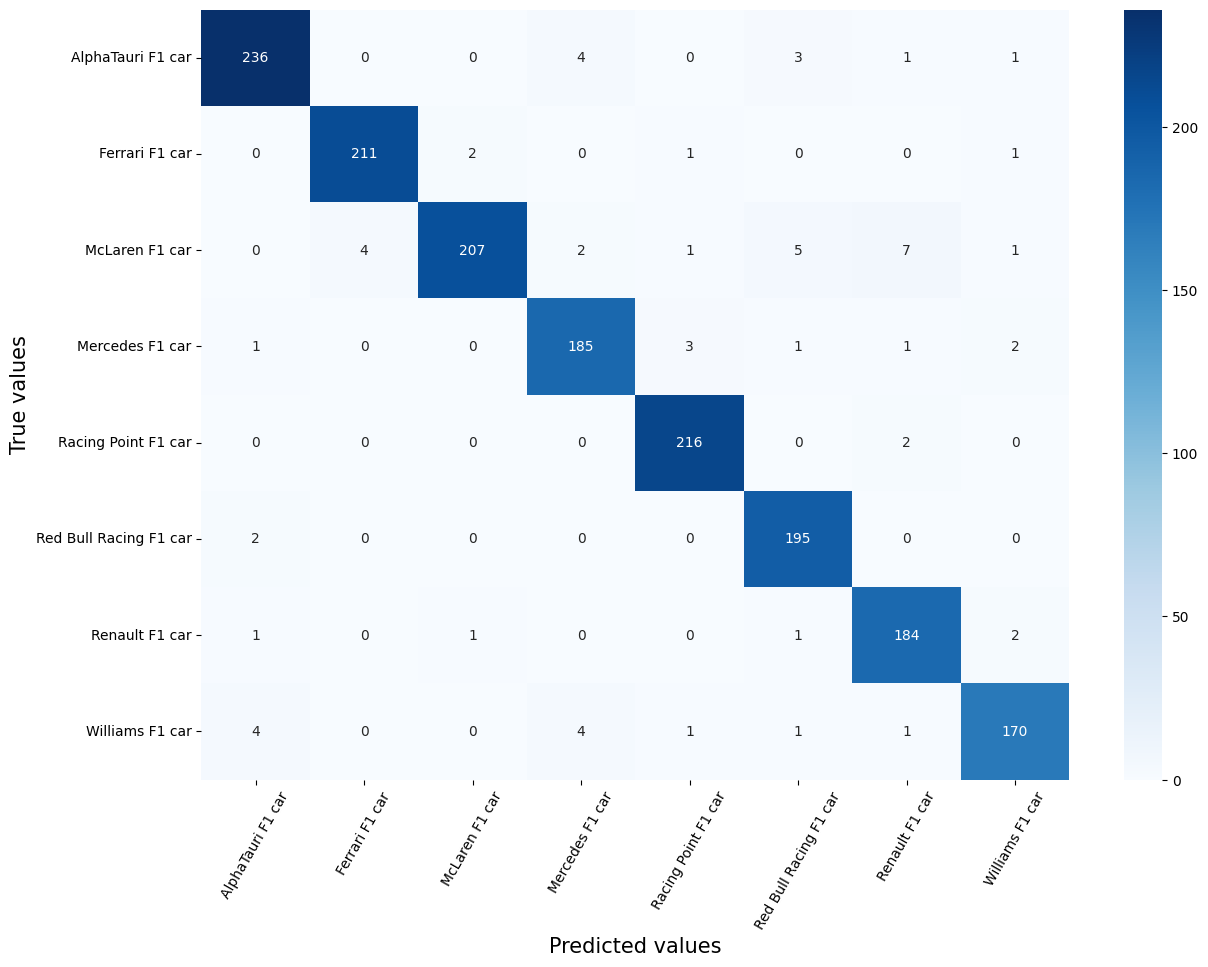

In [49]:
val_labels_cpu = val_labels.cpu()
make_confusion_matrix(true_labels,val_labels_cpu,dataset.classes)